In [1]:
from importlib import reload
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn3
import seaborn as sns
import networkx as nx
import itertools
import pickle
from tqdm import tqdm
import gseapy
from gseapy.plot import barplot, dotplot
from causaldag import rand, partial_correlation_suffstat, partial_correlation_test, MemoizedCI_Tester, gsp, PDAG, DAG
import viz_dag as vd

In [15]:
# Specify directories
data_dir = "../data/"
save_dir = "../save/"

# Exploratory data analysis
- Article: https://www.nature.com/articles/s41588-021-00779-1
- Data: https://singlecell.broadinstitute.org/single_cell/study/SCP1064/multi-modal-pooled-perturb-cite-seq-screens-in-patient-models-define-novel-mechanisms-of-cancer-immune-evasion#study-download

### Load cell informations

In [3]:
# Combine sgRNAs assignments and RNA metadata
sgRNA_assignments_df = pd.read_csv(data_dir+'all_sgRNA_assignments.txt', header=0, index_col=0,
                                   names=['cell', 'sgRNAs'])
RNA_metadata_df = pd.read_csv(data_dir+'RNA_metadata.csv', header=0, index_col=0,
                              names=['cell', 'library_prep', 'condition', 'MOI', 'sgRNA', 'UMI_count'])
RNA_UMAP_df = pd.read_csv(data_dir+'RNA_UMAP_cluster.csv', header=0, index_col=0,
                          names=['cell', 'UMAP1', 'UMAP2'])
cell_metadata_df = pd.concat([RNA_metadata_df, sgRNA_assignments_df, RNA_UMAP_df], axis=1)

In [4]:
# Include additional information
cell_metadata_df['sgRNAs'] = cell_metadata_df['sgRNAs'].astype(str)
cell_metadata_df['sgRNAs'] = cell_metadata_df['sgRNAs'].str.replace('nan','')
cell_metadata_df['sgRNAs'] = cell_metadata_df['sgRNAs'].apply(lambda x: x.split(','))
cell_metadata_df = cell_metadata_df[['library_prep', 'condition', 'UMI_count', 'MOI', 'sgRNAs', 'UMAP1', 'UMAP2']]

In [5]:
# Dtermine unique target genes for each cell
cell_metadata_df['target_genes'] = cell_metadata_df['sgRNAs'].apply(lambda x: np.unique([guide.split('_')[0] 
                                                                                        for guide in x]))
cell_metadata_df['target_genes_id'] = cell_metadata_df['target_genes'].apply(lambda x: '_'.join(sorted(x)))
cell_metadata_df['n_target_genes'] = cell_metadata_df['target_genes'].apply(lambda x: len(x) if x[0]!='' else 0)
cell_metadata_df.head()

,library_prep,condition,UMI_count,MOI,sgRNAs,UMAP1,UMAP2,target_genes,target_genes_id,n_target_genes
cell,,,,,,,,,,
CELL_1,10X 3' v3 sequencing,Control,10832.0,1,[HLA-B_2],-3.937523,5.441272,[HLA-B],HLA-B,1
CELL_2,10X 3' v3 sequencing,Control,10731.0,2,"[NGFR_3, SERPINF1_3]",-5.480882,6.598254,"[NGFR, SERPINF1]",NGFR_SERPINF1,2
CELL_3,10X 3' v3 sequencing,Control,28821.0,1,[HLA-B_2],-1.044962,9.840532,[HLA-B],HLA-B,1
CELL_4,10X 3' v3 sequencing,Control,15322.0,2,"[NMRK1_3, S100A6_3]",-2.588797,6.588356,"[NMRK1, S100A6]",NMRK1_S100A6,2
CELL_5,10X 3' v3 sequencing,Control,10314.0,0,[],-0.795585,2.256979,[],,0


### Load gene information

In [6]:
# Genes measured in scRNA-seq data
genes_df = pd.read_csv(data_dir+'RNA_genenames.csv', header=0, index_col=0)
genes_list = genes_df['genes'].values
n_genes = len(genes_list)
print(f'Total number of genes measured = {n_genes}')

Total number of genes measured = 23712


### Information across all screens

In [7]:
# General information
n_cells_all = len(cell_metadata_df)
all_guides = np.unique(sorted(itertools.chain.from_iterable(cell_metadata_df['sgRNAs'].values)))[1:]
all_positive_guides = np.array([guide for guide in all_guides 
                            if ((guide[:17]!='ONE_NON-GENE_SITE') & (guide[:7]!='NO_SITE'))])
all_ntc_guides = np.array([guide for guide in all_guides
                      if ((guide[:17]=='ONE_NON-GENE_SITE') | (guide[:7]=='NO_SITE'))])
all_genes_targeted = np.unique([guide.split('_')[0] for guide in all_positive_guides])
print(f'Total number of cells = {n_cells_all}')
print(f'Total number of unique guides = {len(all_guides)}')
print(f'Total number of unique positive guides = {len(all_positive_guides)}')
print(f'Total number of unique control guides = {len(all_ntc_guides)}')
print(f'Total number of unique genes targeted = {len(all_genes_targeted)}')

Total number of cells = 218331
Total number of unique guides = 818
Total number of unique positive guides = 744
Total number of unique control guides = 74
Total number of unique genes targeted = 248


### Basic information about the screens

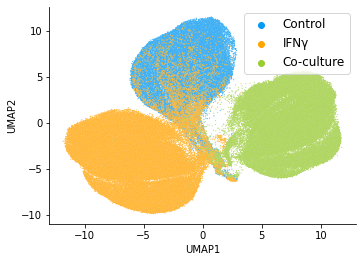

In [8]:
# Visualization (UMAP based on scRNAseq)
fig, ax = plt.subplots(1,1,figsize=(5.2, 3.8))
plt.rcParams.update({'font.size': 12})
sns.scatterplot(data=cell_metadata_df, x='UMAP1', y='UMAP2', hue='condition', alpha=1, s=1, palette=['#069AF3', 'orange',  '#9ACD32'])
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig('../../figures/umap_batch.pdf')
# plt.show()

In [9]:
# Number of cells
conditions = cell_metadata_df["condition"].unique()
n_cells = {c: len(cell_metadata_df[cell_metadata_df['condition']==c]) for c in conditions}
screens_size = pd.DataFrame({'condition': n_cells.keys(), 'n_cells': n_cells.values()})
print(f'Conditions = {conditions}')
print(f'Total number of cells in control = {n_cells["Control"]}')
print(f'Total number of cells in IFNγ = {n_cells["IFNγ"]}')
print(f'Total number of cells in co-culture = {n_cells["Co-culture"]}')

Conditions = ['Control' 'IFNγ' 'Co-culture']
Total number of cells in control = 57627
Total number of cells in IFNγ = 87590
Total number of cells in co-culture = 73114


In [10]:
# General information on guides and targets
guides = {c: np.unique(
    sorted(itertools.chain.from_iterable(cell_metadata_df[cell_metadata_df['condition']==c]['sgRNAs'].values))
)[1:] for c in conditions}
positive_guides = {c: np.array([guide for guide in guides[c] 
                                if ((guide[:17]!='ONE_NON-GENE_SITE') & (guide[:7]!='NO_SITE'))]) 
                   for c in conditions}
ntc_guides = {c: np.array([guide for guide in guides[c] 
                           if ((guide[:17]=='ONE_NON-GENE_SITE') | (guide[:7]=='NO_SITE'))]) 
              for c in conditions}
genes_targeted ={c: np.unique([guide.split('_')[0] for guide in positive_guides[c]]) for c in conditions}
all_perturb = {c: np.sort(cell_metadata_df[cell_metadata_df['condition']==c]['target_genes_id'].unique()) 
               for c in conditions}

In [11]:
# Create summary dataframe
summary_df = pd.DataFrame(0, index=conditions, columns=['n_cells', 
                                                        'n_pos_guides', 'n_ntc_guides', 
                                                        'n_genes_pert', 'n_combinations_pert'])
for c in conditions:
    summary_df.loc[c, 'n_cells'] = n_cells[c]
    summary_df.loc[c, 'n_pos_guides'] = len(positive_guides[c])
    summary_df.loc[c, 'n_ntc_guides'] = len(ntc_guides[c])
    summary_df.loc[c, 'n_genes_pert'] = len(genes_targeted[c])
    summary_df.loc[c, 'n_combinations_pert'] = len(all_perturb[c])
summary_df

,n_cells,n_pos_guides,n_ntc_guides,n_genes_pert,n_combinations_pert
Control,57627,743,74,248,17156
IFNγ,87590,744,74,248,19131
Co-culture,73114,742,74,248,13217


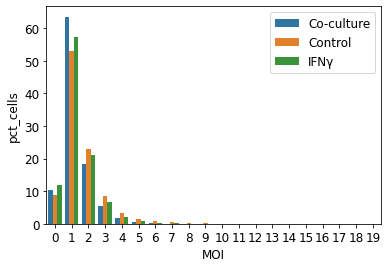

In [12]:
# MOI for all three conditions (number of distinct sgRNA oper cell)
grouped_data = cell_metadata_df.groupby(['condition', 'MOI']).size().to_frame('size').reset_index()
grouped_data = grouped_data.merge(screens_size, how='outer', on='condition')
grouped_data['pct_cells'] = 100*grouped_data['size']/grouped_data['n_cells']
plt.figure()
sns.barplot(data=grouped_data, x='MOI', y='pct_cells', hue='condition')
plt.legend(loc='upper right')
plt.show()

### Dictionary of available perturbations for each screen

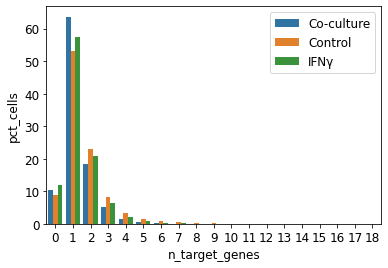

In [13]:
# Number of genes targeted for all three conditions (number of distinct sgRNA oper cell)
grouped_data2 = cell_metadata_df.groupby(['condition', 'n_target_genes']).size().to_frame('size').reset_index()
grouped_data2 = grouped_data2.merge(screens_size, how='outer', on='condition')
grouped_data2['pct_cells'] = 100*grouped_data2['size']/grouped_data2['n_cells']
plt.figure()
sns.barplot(data=grouped_data2, x='n_target_genes', y='pct_cells', hue='condition')
plt.legend(loc='upper right')
plt.show()

In [14]:
# # Build dictionary

# pertub_dict = {'Control': {}, 'IFNγ': {}, 'Co-culture': {}}

# for pert in tqdm(all_perturb)

# for screen in conditions:
#     pertub_dict[screen] = {pert: cell_metadata_df[(cell_metadata_df['condition']==screen) &
#                                                   (cell_metadata_df['target_genes_id']==pert)].index.values 
#                            for pert in tqdm(all_perturb[screen])}
# # with open(save_dir+'pertub_dict.pkl', 'wb') as f:
# #     pickle.dump(pertub_dict, f)

### Example: access scRNA-seq data for a given perturbation in a given screen

In [16]:
# Load screen-pertubation-sample dictionary
with open(save_dir+'pertub_dict.pkl', 'rb') as f:
    pertub_dict = pickle.load(f)

In [17]:
# Screen and perturbation
screen = 'Control'
a = all_perturb[screen][1]
x = pertub_dict[screen][a]

In [18]:
# # scRNA-seq data
# rna_path = data_dir+'RNA_expression.csv'
# selected_rna_df = pd.read_csv(rna_path, header=0, index_col=0, sep=',', usecols=np.concatenate([['GENE'], x]))
# selected_rna_df

# Select genes

### Targeted genes

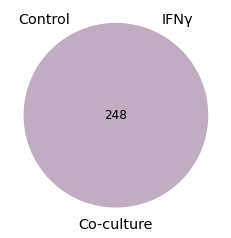

In [19]:
# Compare genes targeted in all screens
plt.figure()
venn3(subsets = [set(genes_targeted[c]) for c in conditions], 
      set_labels = conditions)
plt.show()

In [20]:
# # GO analysis of genes
# enr = gseapy.enrichr(gene_list=list(all_genes_targeted), gene_sets='GO_Biological_Process_2018', organism='Human',
#                      description='targeted_genes', outdir='gsea_top_hic',format='png',
#                      verbose=False)
# print(len(enr.results))
# barplot(enr.res2d, column='Adjusted P-value', title='GO_Biological_Process_2018',
#         cutoff=0.01, top_term=20, figsize=(6.5, 6), color='salmon', ofname=None)

### Select genes for our analysis

In [21]:
# # Identify all genes in top signaling signaling pathways
# top_go_genes = list(itertools.chain.from_iterable(enr.results.head(7)['Genes'].apply(lambda x: x.split(';'))))
# top_go_genes = np.unique(top_go_genes)
# print(f'Number of top GO genes = {len(top_go_genes)}')

# Include no genes from the GO analysis
top_go_genes = []

In [6]:
# Target modules and programs (Figure 4d: cofunctional modules and coregulated programs in Perturb-CITE-seq screen)
module1 = ['CD59', 'CDH19', 'IRF3', 'RB1', 'SOX4', 'SP100']
module2 = ['CD58', 'CTSD', 'CXCR4', 'HLA-C', 'HLA-H', 'NUP50-AS', 'SMAD4']
module3 = ['CDK4', 'CTSA', 'FOS', 'HLA-A', 'HLA-E']
module5 = ['EIF3K', 'LAMP2', 'NPC1', 'NPC2', 'SEC11C', 'FBOX32', 'SAT1']
module6 = ['B2M', 'CCR10', 'HLA-B', 'NGFR', 'TGFB1']
programA = ['CLEC2B', 'CTSA', 'CTSB', 'CTSD', 'HLA-DMA', 'HLA-DPA1', 'HLA-DPB1', 'IDO1', 'IFNGR1', 'IFNGR2', 'IRF3', 'SOX4','STAT1', 'STAT3', 'TGFB1']
programB = ['CD58', 'CD59', 'CITED2', 'IL1B', 'ITGA1', 'JUN', 'JUNB', 'NFKBIA', 'SAT1', 'SOX9', 'SP100', 'VEGFA', 'VEGFC']
programC = ['CDK4', 'CENPA', 'CENPE', 'CENPF', 'CENPK', 'CENPM', 'CENPU', 'CENPW', 'CXCL11', 'CXCL12', 'CXCL13', 'DNMT1', 'EGFR', 'HLA-E', 'PSMA2', 'PSMA5', 'PSMB5', 'PSMB7', 'PSMB9', 'PTPN1', 'NPC2', 'TGIF1', 'TOP2A']
programD = ['CDK6', 'COPA', 'DDIT3', 'HLA-DBQI', 'IL32', 'IL6', 'IL7R', 'KPNA2', 'MRTO4', 'MYC', 'NEDD4', 'NRSP1', 'PARPI', 'PARS', 'SERPINE2', 'TGFB2', 'XBPI']
paper_genes = np.concatenate([module1, module2, module3, module5, module6, 
                              programA, programB, programC, programD])
print(f'Number of genes from the paper = {len(paper_genes)}')

Number of genes from the paper = 98


In [23]:
# Combine gene lists and select final list
combined_gene_list = np.unique(np.concatenate([paper_genes, top_go_genes]))
# Only keep genes that are sequenced in the scRNAseq readout
combined_gene_list = np.array(sorted(set.intersection(*[set(combined_gene_list),set(genes_list)])))
# Only keep genes that have been targeted in the control CRISPR screen
selected_gene_list = np.array(sorted(set.intersection(*[set(combined_gene_list),set(genes_targeted['Control'])])))
print(f'Final number of selected genes = {len(selected_gene_list)}')

Final number of selected genes = 36


In [24]:
# Identify perturbations that only include genes from the selected list
pert_matching_df = pd.DataFrame({'pert_id': all_perturb['Control']})
pert_matching_df['pert_genes'] = pert_matching_df['pert_id'].apply(lambda x: set(x.split('_')))
pert_matching_df['diff_selected'] = pert_matching_df['pert_genes'].apply(lambda x: len(x-set(selected_gene_list)))
pert_matching_df['selected_pert'] = (pert_matching_df['diff_selected']==0)
selected_pert = pert_matching_df[pert_matching_df['selected_pert']]['pert_id'].values
print(f'Number of unique perturbations affecting selected genes = {len(selected_pert)}')

Number of unique perturbations affecting selected genes = 253


# Learn network over selected genes

## read observartional data

In [24]:
# # Load and save observational samples
# obs_sample_names = pertub_dict['Control']['']
# obs_samples = pd.read_csv(rna_path, header=0, index_col=0, sep=',', 
#                           usecols=np.concatenate([['GENE'], obs_sample_names]))
# obs_samples_reduced = obs_samples.loc[selected_gene_list,:]
# obs_samples.to_csv(data_dir+'controlscreen_observational_samples_new.csv')
# obs_samples.to_csv(data_dir+'controlscreen_observational_samples_reduced_new.csv')

In [25]:
# Network and observational data
node_names = sorted(selected_gene_list.copy())
nnodes = len(node_names)
nodes = set(range(nnodes))
obs_sample_names = pertub_dict['Control']['']

In [26]:
# Load observational samples (only measured across selected genes)
obs_samples = pd.read_csv(data_dir+'controlscreen_observational_samples_reduced.csv', header=0, index_col=0)
obs_D = obs_samples.T.sort_index(axis=1).values
print(f'Number of observational samples = {len(obs_sample_names)}')

Number of observational samples = 5039


## fixed orders

In [25]:
# Determine fixed order edges from the article
order_1A = list(itertools.product(module1, programA))
order_1B = list(itertools.product(module1, programB))
order_1C = list(itertools.product(module1, programC))
order_2A = list(itertools.product(module2, programA))
order_2B = list(itertools.product(module2, programB))
order_3B = list(itertools.product(module3, programB))
order_3C = list(itertools.product(module3, programC))
order_3D = list(itertools.product(module3, programD))
order_5A = list(itertools.product(module5, programA))
order_5C = list(itertools.product(module5, programC))
order_5D = list(itertools.product(module5, programD))
order_6C = list(itertools.product(module6, programC))
fixed_orders = list(itertools.chain.from_iterable([order_1A, order_1B, order_1C,
                                              order_2A, order_2B,
                                              order_3B, order_3C, order_3D, 
                                              order_5A, order_5C, order_5D, 
                                              order_6C]))
fixed_orders = set([pair for pair in fixed_orders 
                if ((pair[0] in selected_gene_list) & 
                    (pair[1] in selected_gene_list) & 
                    (pair[0] != pair[1]))])
print(f'Number of fixed orders = {len(fixed_orders)}')

Number of fixed orders = 346


In [26]:
# regulators that are also member of programs
reg_prog_genes = []
for g in selected_gene_list:
	if g in programA + programB + programC + programD and g in module1 + module2 + module3 + module5 + module6:
		reg_prog_genes.append(g)
print(f'Number of selected genes that are both regulators and member of programs = {len(reg_prog_genes)}')		

Number of selected genes that are both regulators and member of programs = 12


Number of self looped genes = 9
Number of fixed orders after removing self loop genes = 117


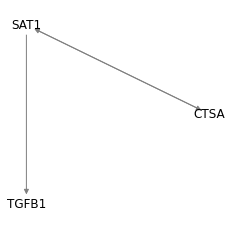

In [27]:
# genes that have self loops
self_loop_genes = []
for g in selected_gene_list:
	if (g,g) in list(itertools.chain.from_iterable([order_1A, order_1B, order_1C, order_2A, order_2B, order_3B, order_3C, order_3D, order_5A, order_5C, order_5D, order_6C])):
		self_loop_genes.append(g)
print(f"Number of self looped genes = {len(self_loop_genes)}")

# remove self looped genes
new_fixed_orders = set()
for i,j in fixed_orders:
	if j not in self_loop_genes and i not in self_loop_genes:
		new_fixed_orders.add((i,j))
print(f'Number of fixed orders after removing self loop genes = {len(new_fixed_orders)}')

G = nx.DiGraph()
G.add_nodes_from([g for g in reg_prog_genes if g not in self_loop_genes])
for i,j in new_fixed_orders:
	if i in G.nodes and j in G.nodes:
		G.add_edge(i,j)
nw_ax = plt.subplot2grid((5, 5), (0, 0), colspan=4, rowspan=4)
plt.gcf().set_size_inches(5, 5)

pos = nx.circular_layout(G)
nx.draw(G, pos=pos, node_color='w', ax=nw_ax, edge_color='grey')
nx.draw_networkx_labels(G, pos, labels={k:k for k in reg_prog_genes if k not in self_loop_genes}, ax=nw_ax, font_size=12);

In [30]:
# new_fixed_orders = set()
# for i,j in fixed_orders:
# 	if (j,i) not in fixed_orders:
# 		new_fixed_orders.add((i,j))
# print(f'Number of fixed orders after resolving conflicts = {len(new_fixed_orders)}')

# G = nx.DiGraph()
# G.add_nodes_from(reg_prog_genes)
# for i,j in new_fixed_orders:
# 	if i in reg_prog_genes and j in reg_prog_genes:
# 		G.add_edge(i,j)

# nw_ax = plt.subplot2grid((10, 10), (0, 0), colspan=9, rowspan=9)
# plt.gcf().set_size_inches(10, 10)

# # pos = graphviz_layout(G, 'dot')
# pos = nx.circular_layout(G)
# nx.draw(G, pos=pos, node_color='w', ax=nw_ax, edge_color='grey')
# nx.draw_networkx_labels(G, pos, labels={k:k for k in reg_prog_genes}, ax=nw_ax, font_size=12);

# from pprint import pprint
# pprint(list(nx.simple_cycles(G)))

# score_edge = {}
# for cycle in nx.simple_cycles(G):
# 	l = len(cycle)
# 	for i in range(l):
# 		edge = (cycle[i], cycle[(i+1)%l])
# 		if edge in score_edge.keys():
# 			score_edge[edge] += 1
# 		else:
# 			score_edge[edge] = 1

# print(sorted(score_edge.items(), key=lambda x:x[1], reverse=True))

In [28]:
# # remove regulators from the programs
# remove genes from both sides
new_fixed_orders = set()
for i,j in fixed_orders:
	if j not in reg_prog_genes and i not in reg_prog_genes:
		new_fixed_orders.add((i,j))
print(f'Number of fixed orders after removing genes from both sides = {len(new_fixed_orders)}')

Number of fixed orders after removing genes from both sides = 75


## learn the dag

In [184]:
# Learn MEC
random.seed(12)
np.random.seed(12)
suffstat = partial_correlation_suffstat(obs_D)
ci_tester = MemoizedCI_Tester(partial_correlation_test, suffstat, alpha=1e-4)
est_dag = gsp(nodes, ci_tester, nruns=1000) #, fixed_orders=new_fixed_orders)

In [158]:
# # Learn MEC using consistent initial permutations
# # remove regulators from the programs
# # remove regulators from both sides
# left_idx = []
# right_idx = []
# idx = []

# name_to_node = {node_names[i]:i for i in range(nnodes)}

# for g in selected_gene_list:
# 	if g in reg_prog_genes:
# 		idx.append(name_to_node[g])
# 	else:
# 		if g in module1 + module2 + module3 + module5 + module6:
# 			left_idx.append(name_to_node[g])
# 		else:
# 			right_idx.append(name_to_node[g])

# initial_perm = []
# for _ in range(1000):
# 	partial_perm = np.random.permutation(list(-np.ones(len(left_idx)+len(right_idx)))+idx)
# 	zero_idx = np.where(partial_perm==-1)[0]
# 	partial_perm[zero_idx] = np.array(list(np.random.permutation(left_idx))+list(np.random.permutation(right_idx)))
# 	initial_perm.append([int(i) for i in partial_perm])

# suffstat = partial_correlation_suffstat(obs_D)
# ci_tester = MemoizedCI_Tester(partial_correlation_test, suffstat, alpha=1e-3)
# est_dag = gsp(nodes, ci_tester, initial_permutations=initial_perm, fixed_orders=new_fixed_orders)

## check consistency

In [185]:
# # Draw DAG
# vd.draw(est_dag, node_names)
# reload(vd)
print(f"Number of edges in the MEC: {len(est_dag.arcs)}")

est_pdag = est_dag.cpdag()

cst_arcs = []
rvsd_arcs = []
seen_edges = []
unseen_edges = []

for i,j in new_fixed_orders:
	i = node_names.index(i)
	j = node_names.index(j)
	
	if est_pdag.has_arc(i,j):
		cst_arcs.append((i,j))
	elif est_pdag.has_arc(j,i):
		rvsd_arcs.append((i,j))
	elif est_pdag.has_edge(i,j):
		seen_edges.append((i,j))
	else:
		unseen_edges.append((i,j))


print(f"Number of reversed arcs: {len(rvsd_arcs)}")
print(f"Number of consistent arcs: {len(cst_arcs)}")
print(f"Number of seen edges: {len(seen_edges)}")
print(f"Number of unseen edges: {len(unseen_edges)}")	

Number of edges in the MEC: 102
Number of reversed arcs: 2
Number of consistent arcs: 2
Number of seen edges: 7
Number of unseen edges: 64


In [186]:
node = est_pdag.nodes
arcs = est_pdag.arcs
edges = est_pdag.edges

name_to_node = {node_names[i]:i for i in range(nnodes)}

for i,j in seen_edges:
	edges.remove(frozenset({i,j}))
	arcs.add((i,j))

pdag = PDAG(node, arcs, edges)

print("Number of DAGs in the class after adding the fixed orders: ", len(pdag.all_dags()))

Number of DAGs in the class after adding the fixed orders:  1


## plot and save

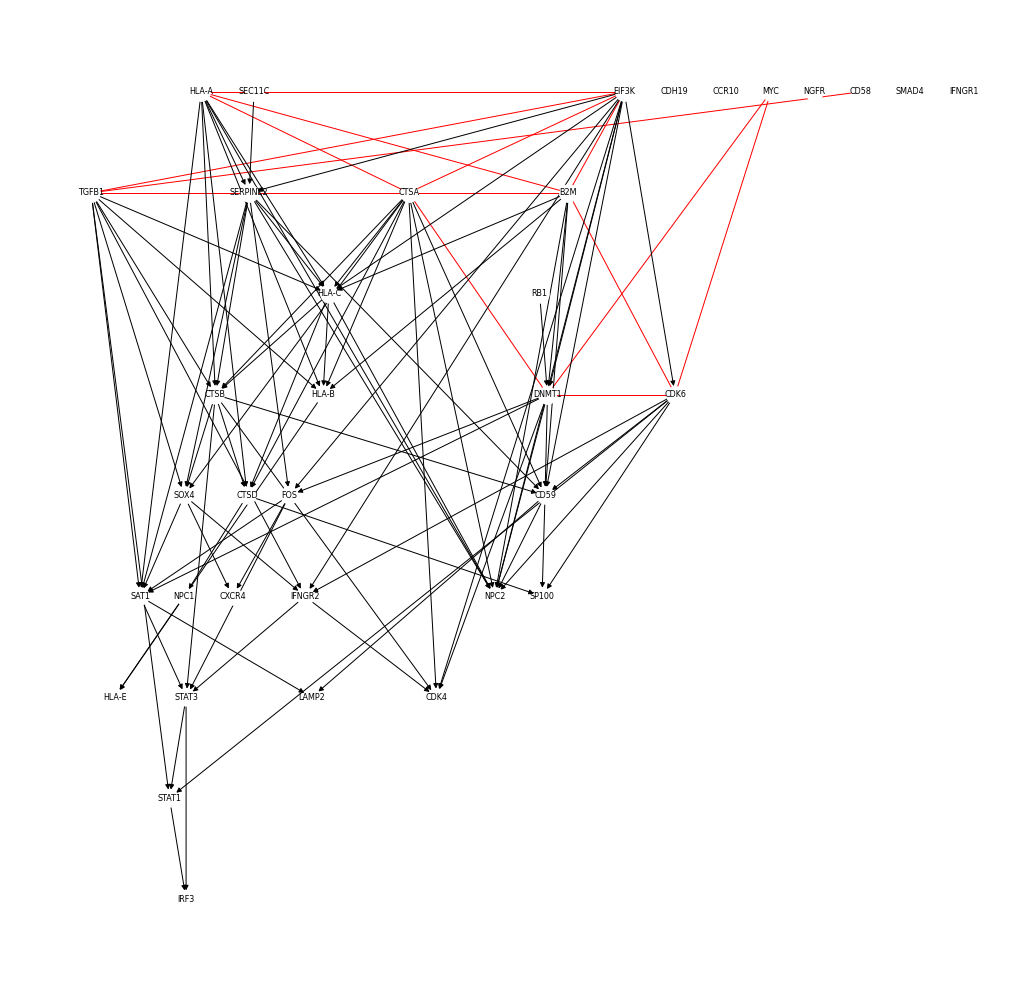

In [187]:
pdag = pdag.rename_nodes({node: node_names[node] for node in range(nnodes)})
vd.draw(pdag)

with open(f"../../data/graphs/pdags/removed_genes-1e_4.pkl", 'wb') as f:
	pickle.dump(pdag, f)

In [188]:
# Convert all consistent dags to networkx graphs and save

for k, arcs in tqdm(enumerate(pdag.all_dags())):
	G = nx.DiGraph()
	G.add_nodes_from(pdag.nodes)
	for (i, j) in arcs:
		G.add_edge(i, j)
	H = nx.relabel_nodes(G, {node: node_names[node] for node in range(nnodes)})
	
	with open(f"../../data/graphs/dags/removed_genes-1e_4-{k}.pkl", 'wb') as f:
		pickle.dump(H, f)



1it [00:00, 603.32it/s]


## Load saved DAG and check

In [2]:
from causaldag import PDAG

with open("../../data/graphs/dags/estimated_dag.pkl", 'rb') as file:
	pdag = pickle.load(file)

# pdag = DAG.from_nx(pdag).cpdag()
# reload(vd)
# vd.draw(dag)

cst_arcs = []
rvsd_arcs = []
unseen_arcs = []

for i,j in new_fixed_orders:
	if pdag.has_arc(i,j):
		cst_arcs.append((i,j))
	elif pdag.has_arc(j,i):
		rvsd_arcs.append((i,j))
	else:
		unseen_arcs.append((i,j))

print(f"Number of reversed arcs: {len(rvsd_arcs)}")
print(f"Number of consistent arcs: {len(cst_arcs)}")
print(f"Number of unseen arcs: {len(unseen_arcs)}")	

NameError: name 'pickle' is not defined

In [49]:
dpdag = nx.DiGraph()
dpdag.add_nodes_from(pdag.nodes)
dpdag.add_edges_from(pdag.arcs)

In [50]:
cst_orders = []
rvsd_orders = []
unseen_orders = []

for i,j in new_fixed_orders:
	if nx.has_path(dpdag, i, j):
		cst_orders.append((i,j))
	elif nx.has_path(dpdag, j, i):
		rvsd_orders.append((i,j))
	else:
		unseen_orders.append((i,j))

print(f"Number of reversed orders: {len(rvsd_orders)}")
print(f"Number of consistent orders: {len(cst_orders)}")
print(f"Number of unseen orders: {len(unseen_orders)}")	

Number of reversed orders: 0
Number of consistent orders: 1
Number of unseen orders: 74


## Plot

In [2]:
import pickle

with open("../../data/graphs/dags/estimated_dag.pkl", 'rb') as file:
	dag = pickle.load(file)

In [3]:
dag.nodes

NodeView(('B2M', 'CCR10', 'CD58', 'CD59', 'CDH19', 'CDK4', 'CDK6', 'CTSA', 'CTSB', 'CTSD', 'CXCR4', 'DNMT1', 'EIF3K', 'FOS', 'HLA-A', 'HLA-B', 'HLA-C', 'HLA-E', 'IFNGR1', 'IFNGR2', 'IRF3', 'LAMP2', 'MYC', 'NGFR', 'NPC1', 'NPC2', 'RB1', 'SAT1', 'SEC11C', 'SERPINE2', 'SMAD4', 'SOX4', 'SP100', 'STAT1', 'STAT3', 'TGFB1'))

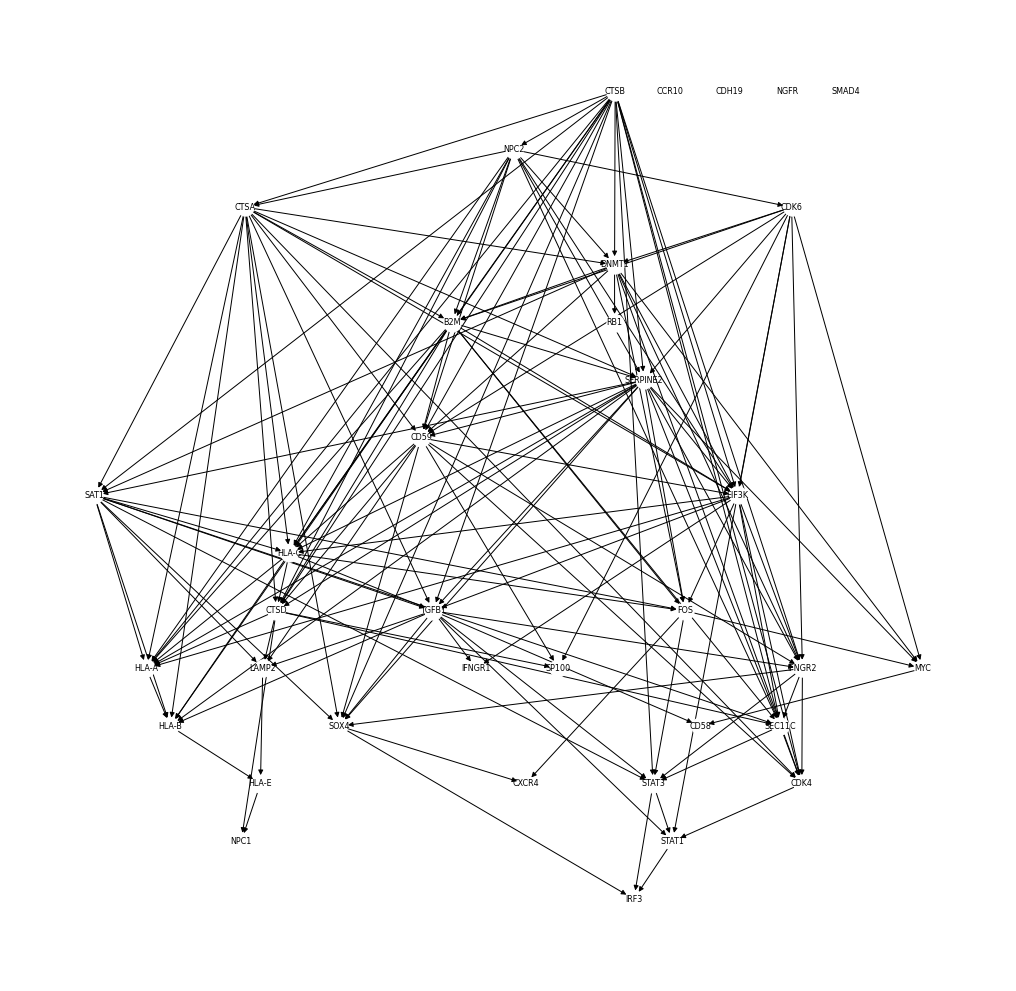

In [4]:
from networkx.drawing.nx_agraph import graphviz_layout

nw_ax = plt.subplot2grid((10, 10), (0, 0), colspan=9, rowspan=9)
plt.gcf().set_size_inches(20, 20)
pos = graphviz_layout(dag, 'dot')
nx.draw(dag, pos=pos, node_color='w', ax=nw_ax)

nx.draw_networkx_labels(dag, pos, labels={s:s for s in dag.nodes}, ax=nw_ax, font_size=8);

In [7]:
color_dict = {}
for g in module1:
	color_dict[g] = 'lightskyblue'
for g in module2:
	color_dict[g] = 'lightgreen'
for g in module3:
	color_dict[g] = 'orchid1'
for g in module5:
	color_dict[g] = 'khaki1'
for g in module6:
	color_dict[g] = 'tan'

b_color_dict = {}
for g in programA:
	b_color_dict[g] = 'cornflowerblue'
for g in programB:
	b_color_dict[g] = 'darkseagreen'
for g in programC:
	b_color_dict[g] = 'sandybrown'
for g in programD:
	b_color_dict[g] = 'mediumpurple'

In [18]:
import graphviz

g = graphviz.Digraph('G')
g.attr(ratio='0.6')

for node in dag.nodes:
	color = color_dict[node] if node in color_dict.keys() else 'white'
	b_color = b_color_dict[node] if node in b_color_dict.keys() else 'black'
	g.node(node, style='filled,setlinewidth(12)', fillcolor=color, color=b_color, width='4.8', height='3.6', fontsize='72', fontname='Bold-Times-Roman')

for (i,j) in dag.edges:
	g.edge(i,j, style='setlinewidth(6)', color='darkgrey', arrowsize='3')

g.view()

'G.gv.pdf'